In [2]:
# !pip install torchinfo

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Checking if a GPU is available for training a model
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 4252372146625191947
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14619377664
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 10358421039185088036
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419,
 name: "/device:GPU:1"
 device_type: "GPU"
 memory_limit: 14619377664
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 18395687570030862135
 physical_device_desc: "device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5"
 xla_global_id: 2144165316]

In [5]:
# Display detailed information about the system's memory
# !cat /proc/meminfo

In [6]:
# Display detailed information about the system's central processing unit (CPU)
# !cat /proc/cpuinfo

In [7]:
# !pip install --upgrade --force-reinstall --no-deps kaggle==1.5.8
# !mkdir /root/.kaggle

# with open("/root/.kaggle/kaggle.json", "w+") as f:
#     f.write('{"username":"khushalidaga08","key":"c7aaa2a8acee7e33b56fe4195f198b4d"}')
#     # Put your kaggle username & key here

# !chmod 600 /root/.kaggle/kaggle.json

<h1> Part 1: Data Acquisition and Preprocessing <h1>

In [11]:
!kaggle datasets download behrad3d/nasa-cmaps
! mkdir train
! unzip nasa-cmaps.zip -d train

Dataset URL: https://www.kaggle.com/datasets/behrad3d/nasa-cmaps
License(s): CC0-1.0
nasa-cmaps.zip: Skipping, found more recently modified local copy (use --force to force download)
mkdir: cannot create directory 'train': File exists
Archive:  nasa-cmaps.zip
replace train/CMaps/Damage Propagation Modeling.pdf? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [4]:
PM_train = '/kaggle/working/train/CMaps/train_FD001.txt'
PM_test = '/kaggle/working/train/CMaps/test_FD001.txt'
PM_truth = '/kaggle/working/train/CMaps/RUL_FD001.txt'

# Binary classification
Predict if an asset will fail within certain time frame (e.g. cycles)

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Setting seed for reproducibility
np.random.seed(1234)
PYTHONHASHSEED = 0

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM, GRU
from torchinfo import summary
import keras

# define path to save model
model_path = 'binary_model.keras'

## Data Ingestion

In [6]:
# Read training data - Aircraft engine run-to-failure data
train_df = pd.read_csv(PM_train, sep=' ', header=None) # Read the txt file, use appropriate separator and header
train_df.drop([26, 27], axis=1, inplace=True)  # Explore the data on your own and remove unnecessary columns
train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3'] + [f'sensor{i}' for i in range(1, 22)]   # Assign names to all the columns

train_df = train_df.sort_values(['id', 'cycle'])  # Sort by id and cycle

# # Read test data - Aircraft engine operating data without failure events recorded
test_df = pd.read_csv(PM_test, sep=' ', header=None)  # Read the txt file, use appropriate separator and header
test_df.drop([26, 27], axis=1, inplace=True)  # Explore the data on your own and remove unnecessary columns
test_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3'] + [f'sensor{i}' for i in range(1, 22)] # Assign names to all the columns

# # Read ground truth data - True remaining cycles for each engine in testing data
truth_df = pd.read_csv(PM_truth, sep=' ', header=None) # Read the txt file, use appropriate separator and header
truth_df.drop(1, axis=1, inplace=True)  # Explore the data on your own and remove unnecessary columns

## Data Preprocessing

In [7]:
#######
# TRAIN
#######
# Data Labeling - generate column RUL (Remaining Useful Life or Time to Failure)

# TODO: Calculate the maximum cycle value for each engine (id) and store it in a new DataFrame (rul)
rul = train_df.groupby('id')['cycle'].max().reset_index()
# TODO: Rename the columns in the rul DataFrame
rul.columns = ['id', 'max_cycle']
# TODO: Merge the rul DataFrame with the original train_df based on the 'id' column
train_df = train_df.merge(rul, on='id', how='left')
# TODO: Calculate the Remaining Useful Life (RUL) by subtracting the current cycle from the maximum cycle
train_df['RUL'] = train_df['max_cycle'] - train_df['cycle']
# TODO: Remove the temporary column used to calculate RUL
train_df.drop('max_cycle', axis=1, inplace=True)

# Generate label columns for training data
# We will only make use of "label1" for binary classification,
# while trying to answer the question: is a specific engine going to fail within w1 cycles?
w1 = 30
w0 = 15

# TODO: Create a binary label ('label1') indicating if the engine will fail within w1 cycles (1) or not (0)
train_df['label1'] = train_df['RUL'].apply(lambda x: 1 if x <= w1 else 0)  # Replace with the correct threshold value and label values
# TODO: Initialize a second label ('label2') as a copy of 'label1'
train_df['label2'] = train_df['label1'].copy()
# TODO: Update 'label2' to indicate if the engine will fail within w0 cycles (2) or not (0/1)
train_df.loc[train_df['RUL'] <= w0, 'label2'] = 2 # Replace with the correct threshold value and label value


# MinMax normalization (from 0 to 1)
# TODO: Create a normalized version of the 'cycle' column (e.g., 'cycle_norm') using the original 'cycle' values
train_df['cycle_norm'] = train_df['cycle'] / train_df.groupby('id')['cycle'].transform('max')  # Replace with the correct normalization code
# TODO: Select the columns to be normalized (all columns except 'id', 'cycle', 'RUL', 'label1', and 'label2')
cols_normalize = train_df.columns.difference(['id', 'cycle', 'RUL', 'label1', 'label2'])  # Replace with the correct column selection code
# TODO: Initialize a MinMaxScaler object to scale values between 0 and 1
min_max_scaler = preprocessing.MinMaxScaler()  # Replace with the correct scaler initialization code
# TODO: Apply MinMaxScaler to the selected columns and create a new normalized DataFrame
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]), columns=cols_normalize)  # Replace with the correct normalization code
# TODO: Join the normalized DataFrame with the original DataFrame (excluding normalized columns)
join_df = train_df[['id', 'cycle', 'RUL', 'label1', 'label2']].join(norm_train_df)  # Replace with the correct join code
# TODO: Reorder the columns in the joined DataFrame to match the original order
train_df = join_df.reindex(columns=train_df.columns)  # Replace with the correct reindexing code

######
# TEST
######
# MinMax normalization (from 0 to 1)
# TODO: Similar to the MinMax normalization done for Train, complete the code below.
test_df['cycle_norm'] = test_df['cycle'] / test_df.groupby('id')['cycle'].transform('max')
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]), columns=cols_normalize)
test_join_df = test_df[['id', 'cycle']].join(norm_test_df)
test_df = test_join_df.reindex(columns=test_df.columns)
# test_df = NotImplemented

# We use the ground truth dataset to generate labels for the test data.
# generate column max for test data
# TODO: Calculate the maximum cycle value for each engine (id) in the test data and store it in a new DataFrame (rul)
rul = test_df.groupby('id')['cycle'].max().reset_index()
# TODO: Rename the columns in the rul DataFrame
rul.columns = ['id', 'max']
# TODO: Merge the rul DataFrame with the original test_df based on the 'id' column
truth_df.columns = ['more']
truth_df['id'] = truth_df.index + 1
truth_df['max'] = rul['max'] + truth_df['more']
# TODO: Remove the temporary column used to calculate RUL
truth_df.drop(['more'], axis=1, inplace=True)

# TODO: Merge the adjusted truth_df with the test_df to generate RUL values for test data
test_df = test_df.merge(truth_df[['id', 'max']], on='id', how='left')
# TODO: Calculate the Remaining Useful Life (RUL) by subtracting the current cycle from the maximum cycle
test_df['RUL'] = test_df['max'] - test_df['cycle']
# TODO: Remove the temporary column used to calculate RUL
test_df.drop('max', axis=1, inplace=True)

# Generate binary label columns (label1 and label2) based on RUL values and thresholds w0 and w1
# TODO: Similar to what you did in the train dataframe
test_df['label1'] = test_df['RUL'].apply(lambda x: 1 if x <= w1 else 0)
test_df['label2'] = test_df['label1'].copy()
test_df.loc[test_df['RUL'] <= w0, 'label2'] = 2

<h2>Feature Engineering</h2>

In [8]:
# 1. Feature Engineering: Calculate Moving Averages
# We calculate the moving averages for sensor measurements using a 3-cycle (time step) window.
# The window size of 3 is used to smooth short-term fluctuations, providing more stable trend values.
# This approach helps capture trends in the data while reducing noise.
window_size = 3

for col in train_df:
    # Calculate moving average for each unit in the training data
    train_df[f'{col}_moving_avg'] = train_df.groupby('id')[col].rolling(window=window_size).mean().reset_index(drop=True)
    
    # Apply the same moving average calculation for the test data
    test_df[f'{col}_moving_avg'] = test_df.groupby('id')[col].rolling(window=window_size).mean().reset_index(drop=True)

# Output: Display the first few rows of the training data with moving averages
print("Train data with moving averages (first few rows):")
train_df[[col for col in train_df.columns if '_moving_avg' in col]].head()


Train data with moving averages (first few rows):


,id_moving_avg,cycle_moving_avg,setting1_moving_avg,setting2_moving_avg,setting3_moving_avg,sensor1_moving_avg,sensor2_moving_avg,sensor3_moving_avg,sensor4_moving_avg,sensor5_moving_avg,...,sensor16_moving_avg,sensor17_moving_avg,sensor18_moving_avg,sensor19_moving_avg,sensor20_moving_avg,sensor21_moving_avg,RUL_moving_avg,label1_moving_avg,label2_moving_avg,cycle_norm_moving_avg
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,2.0,0.440613,0.388889,0.0,0.0,0.270080,0.409781,0.344306,0.0,...,0.0,0.277778,0.0,0.0,0.669251,0.692350,190.0,0.0,0.0,0.007675
3,1.0,3.0,0.467433,0.500000,0.0,0.0,0.323293,0.359567,0.351452,0.0,...,0.0,0.277778,0.0,0.0,0.622739,0.671592,189.0,0.0,0.0,0.012898
4,1.0,4.0,0.394636,0.527778,0.0,0.0,0.345382,0.294383,0.368782,0.0,...,0.0,0.305556,0.0,0.0,0.596899,0.662754,188.0,0.0,0.0,0.018121


In [9]:
# 2. Feature Engineering: Create Trend Features (differences between consecutive sensor readings)
# We calculate the trend for each sensor reading by computing the difference between consecutive values.
# This captures the rate of change or trend in sensor measurements over time, helping to identify acceleration or deceleration in sensor behavior.

# Loop through all sensor measurement columns and calculate the difference between consecutive rows (i.e., trend).
# The 'diff()' function calculates the difference, and 'fillna(0)' replaces the first NaN value (which has no previous row) with 0.
for col in train_df.columns:
    train_df[f'{col}_trend'] = train_df.groupby('id')[col].diff().fillna(0)
    test_df[f'{col}_trend'] = test_df.groupby('id')[col].diff().fillna(0)

# Output: Display the first few rows of the trend features in the training data
train_df[[col for col in train_df.columns if '_trend' in col]].head()

,id_trend,cycle_trend,setting1_trend,setting2_trend,setting3_trend,sensor1_trend,sensor2_trend,sensor3_trend,sensor4_trend,sensor5_trend,...,sensor16_moving_avg_trend,sensor17_moving_avg_trend,sensor18_moving_avg_trend,sensor19_moving_avg_trend,sensor20_moving_avg_trend,sensor21_moving_avg_trend,RUL_moving_avg_trend,label1_moving_avg_trend,label2_moving_avg_trend,cycle_norm_moving_avg_trend
0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000
1,0.0,1.0,0.149425,0.083333,0.0,0.0,0.099398,0.046218,0.042876,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000
2,0.0,1.0,-0.356322,0.500000,0.0,0.0,0.060241,-0.083497,0.017893,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000
3,0.0,1.0,0.287356,-0.250000,0.0,0.0,0.000000,-0.113364,-0.039332,0.0,...,0.0,0.000000,0.0,0.0,-0.046512,-0.020759,-1.0,0.0,0.0,0.005223
4,0.0,1.0,-0.149425,-0.166667,0.0,0.0,0.006024,0.001308,0.073430,0.0,...,0.0,0.027778,0.0,0.0,-0.025840,-0.008837,-1.0,0.0,0.0,0.005223


In [10]:
# 3. Feature Engineering: Aggregate Sensor Statistics (mean, std, min, max)
# We calculate aggregate statistics for each sensor measurement: mean, standard deviation (std), minimum, and maximum.
# These aggregated features summarize sensor data at a broader level, providing key insights into the distribution
# of sensor values for each record.

# List of sensor measurement columns for aggregation
sensor_columns = [col for col in train_df.columns if 'sensor' in col]

# Calculate the mean, std, min, and max of sensor data for each record in both train and test sets
for stat in ['mean', 'std', 'min', 'max']:
    # Aggregating sensor data by specified statistic (e.g., mean, std) and assigning to new columns
    train_df[f'sensor_{stat}'] = train_df[sensor_columns].agg(stat, axis=1)
    test_df[f'sensor_{stat}'] = test_df[sensor_columns].agg(stat, axis=1)

# Output: Display the first few rows of the training data with aggregated features
print("Train data with aggregated features (mean, std, min, max):")
train_df[['sensor_mean', 'sensor_std', 'sensor_min', 'sensor_max']].head()


Train data with aggregated features (mean, std, min, max):


,sensor_mean,sensor_std,sensor_min,sensor_max
0,0.103519,0.224152,0.000000,1.0
1,0.111089,0.228240,-0.098229,1.0
2,0.150490,0.261387,-0.166667,1.0
3,0.152393,0.263366,-0.190843,1.0
4,0.157467,0.258060,-0.142857,1.0


In [11]:
# Check for NaN values in the selected columns
nan_cols = train_df[sensor_columns].columns[train_df[sensor_columns].isna().any()].tolist()
print("Columns with NaN values:", nan_cols)

Columns with NaN values: ['sensor1_moving_avg', 'sensor2_moving_avg', 'sensor3_moving_avg', 'sensor4_moving_avg', 'sensor5_moving_avg', 'sensor6_moving_avg', 'sensor7_moving_avg', 'sensor8_moving_avg', 'sensor9_moving_avg', 'sensor10_moving_avg', 'sensor11_moving_avg', 'sensor12_moving_avg', 'sensor13_moving_avg', 'sensor14_moving_avg', 'sensor15_moving_avg', 'sensor16_moving_avg', 'sensor17_moving_avg', 'sensor18_moving_avg', 'sensor19_moving_avg', 'sensor20_moving_avg', 'sensor21_moving_avg']


In [12]:
# Fill NaN values with column means
train_df[sensor_columns] = train_df[sensor_columns].fillna(train_df[sensor_columns].mean())
test_df[sensor_columns] = test_df[sensor_columns].fillna(train_df[sensor_columns].mean())

<h2>Dimensionality Reduction (PCA)<h2>

In [13]:
# Import required libraries
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# 1. Define the sensor measurement columns for PCA
# We focus on columns that contain sensor measurements and optional aggregated statistics.
sensor_columns = [col for col in train_df.columns if 'sensor' in col]

# 2. Add aggregated sensor statistics to the columns for scaling
# Adding key statistics like mean, std, min, and max ensures we're incorporating meaningful aggregate features.
sensor_columns += ['sensor_mean', 'sensor_std', 'sensor_min', 'sensor_max']

# 3. Standardize the data before applying PCA
# Standardization is crucial because PCA is sensitive to the scale of the data.
# Without standardization, features with larger ranges could dominate the principal components.
scaler = StandardScaler()

# Standardize both train and test datasets based on sensor columns
scaled_train = scaler.fit_transform(train_df[sensor_columns])
scaled_test = scaler.transform(test_df[sensor_columns])

# 4. Apply PCA to reduce dimensionality
# PCA is used to capture the key variance in the data by projecting it onto a smaller number of principal components.
# In this case, we're keeping 10 principal components, balancing information retention and dimensionality reduction.
pca = PCA(n_components=10)
pca_train = pca.fit_transform(scaled_train)
pca_test = pca.transform(scaled_test)

# 5. Print explained variance to understand how much variance each principal component captures
print("Explained variance ratio by PCA components:")
print(pca.explained_variance_ratio_)

# 6. Convert PCA output to DataFrames for easier handling
# Each principal component is named 'PCA_1', 'PCA_2', etc., to make the columns easily identifiable.
pca_columns = [f'PCA_{i+1}' for i in range(pca_train.shape[1])]
pca_train_df = pd.DataFrame(pca_train, columns=pca_columns)
pca_test_df = pd.DataFrame(pca_test, columns=pca_columns)

# 7. Reset index to ensure compatibility when concatenating DataFrames
# Resetting ensures that all DataFrames have the same index alignment.
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)
pca_train_df.reset_index(drop=True, inplace=True)
pca_test_df.reset_index(drop=True, inplace=True)

# 8. Concatenate the PCA components with the original DataFrames
# The PCA-transformed data (principal components) are added to the original train and test sets as new features.
train_df = pd.concat([train_df, pca_train_df], axis=1)
test_df = pd.concat([test_df, pca_test_df], axis=1)

# 9. (Optional) Drop original sensor columns to avoid multicollinearity with PCA components
# train_df.drop(columns=sensor_columns, inplace=True)
# test_df.drop(columns=sensor_columns, inplace=True)

# 10. Print the first few rows of the PCA-transformed train data
print("PCA-transformed train data (first few rows):")
train_df[pca_columns].head()

Explained variance ratio by PCA components:
[0.3171633  0.08545943 0.0707351  0.03150895 0.02681323 0.02646574
 0.02613607 0.02554188 0.02499647 0.02463614]
PCA-transformed train data (first few rows):


,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10
0,-3.642867,-1.248042,-1.804310,-2.054354,0.618292,-0.129952,-0.029439,0.284034,-0.530862,-0.235366
1,-3.098473,-0.760131,-2.028719,-1.262724,0.761056,0.201934,-0.063968,-0.565732,-0.326284,-0.265919
2,-4.283693,-0.642444,-0.287126,-0.491321,-0.326775,-1.162490,0.875624,0.038984,0.949834,-0.491154
3,-4.669371,-0.670112,-0.760915,0.380053,-1.255751,1.592330,0.961435,0.685272,-0.008600,1.493743
4,-3.843060,-0.960201,0.218338,0.236477,-1.394100,0.876820,-0.429099,-0.879634,-0.890388,-0.746920


<h1> Part 2: Model Building <h1>

## LSTM

In [14]:
#  window size and sequence length
sequence_length = 50 

def generate_sequences(id_df, sequence_length, feature_columns):
    """Generate sequences from PCA-transformed data for a given id."""
    
    data_matrix = id_df[feature_columns].values
    num_elements = data_matrix.shape[0]
    sequences = []

    # Iterate through data and generate sequences
    for start in range(num_elements):
        end = start + sequence_length
        
        if end <= num_elements:
            # Full sequence
            seq = data_matrix[start:end, :]
        else:
            # Pad sequences shorter than `sequence_length` with zeros
            seq = data_matrix[start:num_elements, :]
            padding = np.zeros((sequence_length - seq.shape[0], data_matrix.shape[1]))
            seq = np.vstack((seq, padding))
        
        sequences.append(seq)
    
    return sequences

# Step 7: Generate and store sequences for all engine ids using PCA-transformed data
def generate_all_sequences(df, sequence_length, feature_columns):
    """Generate sequences for all engine ids after PCA."""
    
    all_sequences = []
    
    for id in df['id'].unique():
        id_df = df[df['id'] == id]
        sequences = generate_sequences(id_df, sequence_length, feature_columns)
        all_sequences.extend(sequences)
    
    return all_sequences

# Step 8: Generate sequences for PCA-transformed data
train_sequences_pca = generate_all_sequences(train_df, sequence_length, pca_columns)

# Step 9: Convert generated sequences to a numpy array for LSTM input
sequence_array_pca = np.array(train_sequences_pca)

# Output shape for verification
print("Generated sequence array shape after PCA:", sequence_array_pca.shape)

Generated sequence array shape after PCA: (20631, 50, 10)


In [15]:
# TODO: Function to generate labels
def generate_labels(id_df, sequence_length, label_column):
    """Generate labels for sequences, including handling shorter sequences at the end."""
    data_matrix = id_df[label_column].values
    num_elements = data_matrix.shape[0]
    labels = []
    
    for start in range(num_elements):
        end = start + sequence_length
        if end <= num_elements:
            # Use the label at the end of the sequence
            label = data_matrix[end - 1]
        else:
            # For sequences shorter than sequence_length, use the last available label
            label = data_matrix[-1]
        labels.append(label)
    
    return labels  # TODO: Replace with the correct code to generate labels

# TODO: Generate labels for all engine ids in the training data
label_generator = (generate_labels(train_df[train_df['id'] == id], sequence_length, 'label1') 
                   for id in train_df['id'].unique())  # TODO: Replace with the correct code to generate labels for all engine ids
label_array = np.concatenate([np.array(list(labels)) for labels in label_generator]).reshape(-1, 1)  # TODO: Replace with the correct code to convert labels to a numpy array
print("Label array shape:", label_array.shape)

Label array shape: (20631, 1)


In [16]:
# Define the number of features and output units
nb_features = sequence_array_pca.shape[2]
nb_out = label_array.shape[1]

# Create a Sequential model
model_lstm = Sequential()

# Add LSTM layers and Dropout layers to the model
model_lstm.add(LSTM(units=10, return_sequences=True, input_shape=(sequence_length, nb_features)))
model_lstm.add(Dropout(0.5))  # Dropout layer to prevent overfitting

model_lstm.add(LSTM(units=20, return_sequences=True))
model_lstm.add(Dropout(0.5))

model_lstm.add(LSTM(units=10, return_sequences=False))
model_lstm.add(Dropout(0.5))

# Add a Dense output layer with sigmoid activation
model_lstm.add(Dense(units=nb_out, activation='sigmoid'))

# Compile the model with binary crossentropy loss and Adam optimizer
model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the model summary to verify the architecture
model_lstm.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50, 10)         │           840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 10)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50, 20)         │         2,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50, 20)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 10)             │         1,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,571 (17.86 KB)

 Trainable params: 4,571 (17.86 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# Fit the network to the training data with callbacks for early stopping and model checkpointing
history_lstm = model_lstm.fit(
    sequence_array_pca,
    label_array,
    epochs=50,  # Number of training epochs
    batch_size=100,  # Batch size (you can experiment with different values)
    validation_split=0.2,  # Proportion of data to use for validation
    verbose=1,  # Verbosity level
    callbacks=[
        # Early stopping callback to stop training when validation loss stops improving
        keras.callbacks.EarlyStopping(
            monitor='val_loss',
            min_delta=0.001,  # Minimum change to consider as improvement
            patience=10,  # Number of epochs with no improvement before stopping
            verbose=1,
            mode='min'
        ),
        # Model checkpoint callback to save the best model based on validation loss
        keras.callbacks.ModelCheckpoint(
            'best_model.keras',  # File path to save the best model
            monitor='val_loss',
            save_best_only=True,
            mode='min',
            verbose=1
        )
    ]
)

Epoch 1/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7989 - loss: 0.4661
Epoch 1: val_loss improved from inf to 0.14616, saving model to best_model.keras
166/166 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.7994 - loss: 0.4653 - val_accuracy: 0.9571 - val_loss: 0.1462
Epoch 2/50
164/166 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9607 - loss: 0.1642
Epoch 2: val_loss improved from 0.14616 to 0.09927, saving model to best_model.keras
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9608 - loss: 0.1638 - val_accuracy: 0.9639 - val_loss: 0.0993
Epoch 3/50
162/166 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9728 - loss: 0.1020
Epoch 3: val_loss improved from 0.09927 to 0.09184, saving model to best_model.keras
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9728 - loss: 0.1019 - val_accuracy: 0.9622 - val_loss: 0.0918
Epoch 4/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9760 - loss: 0.0821
Epoch 4: val_loss did not improve from 0.09184


<h3>Trial with different hyperparameters yielded the best accuracy of 98.80% for the above combination with LSTM.<h3?

In [18]:
# Create a Sequential model using GRU
model_gru = Sequential()

# Add GRU layers and Dropout layers to the model
model_gru.add(GRU(units=10, return_sequences=True, input_shape=(sequence_length, nb_features)))
model_gru.add(Dropout(0.5))  # Dropout layer to prevent overfitting

model_gru.add(GRU(units=20, return_sequences=True))
model_gru.add(Dropout(0.5))

model_gru.add(GRU(units=10, return_sequences=False))
model_gru.add(Dropout(0.5))

# Add a Dense output layer with sigmoid activation
model_gru.add(Dense(units=nb_out, activation='sigmoid'))

# Compile the model with binary crossentropy loss and Adam optimizer
model_gru.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the model summary to verify the architecture
model_gru.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 50, 10)         │           660 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50, 10)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 50, 20)         │         1,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 50, 20)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 10)             │           960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,551 (13.87 KB)

 Trainable params: 3,551 (13.87 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# Fit the network to the training data with callbacks for early stopping and model checkpointing
history_gru = model_gru.fit(
    sequence_array_pca,
    label_array,
    epochs=50,  # Number of training epochs
    batch_size=100,  # Batch size (you can experiment with different values)
    validation_split=0.2,  # Proportion of data to use for validation
    verbose=1,  # Verbosity level
    callbacks=[
        # Early stopping callback to stop training when validation loss stops improving
        keras.callbacks.EarlyStopping(
            monitor='val_loss',
            min_delta=0.001,  # Minimum change to consider as improvement
            patience=10,  # Number of epochs with no improvement before stopping
            verbose=1,
            mode='min'
        ),
        # Model checkpoint callback to save the best model based on validation loss
        keras.callbacks.ModelCheckpoint(
            'best_model_gru.keras',  # File path to save the best model
            monitor='val_loss',
            save_best_only=True,
            mode='min',
            verbose=1
        )
    ]
)

Epoch 1/50
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7160 - loss: 0.4664
Epoch 1: val_loss improved from inf to 0.15743, saving model to best_model_gru.keras
166/166 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.7176 - loss: 0.4645 - val_accuracy: 0.9472 - val_loss: 0.1574
Epoch 2/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9494 - loss: 0.1460
Epoch 2: val_loss improved from 0.15743 to 0.12138, saving model to best_model_gru.keras
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9495 - loss: 0.1460 - val_accuracy: 0.9537 - val_loss: 0.1214
Epoch 3/50
162/166 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9632 - loss: 0.1128
Epoch 3: val_loss improved from 0.12138 to 0.11687, saving model to best_model_gru.keras
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9632 - loss: 0.1127 - val_accuracy: 0.9525 - val_loss: 0.1169
Epoch 4/50
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9665 - loss: 0.0942
Epoch 4: val_loss improved from 0.1

<h3>Trial with different hyperparameters yielded the best accuracy of 98.80% for the above combination with GRU.<h3?

<h2> Advanced Feature Engineering <h2>

In [20]:
# 1. Advanced Feature Engineering: Exponential Moving Average (EMA)
# EMA gives more weight to recent observations and is useful for capturing trends that change more quickly.
# We apply this to each sensor measurement and group by 'id' to calculate EMA over each engine's time series data.

for col in sensor_columns:
    # Calculate EMA for each sensor by grouping on 'id'
    train_df[f'{col}_ema'] = train_df.groupby('id')[col].apply(lambda x: x.ewm(span=5).mean()).reset_index(level=0, drop=True)
    test_df[f'{col}_ema'] = test_df.groupby('id')[col].apply(lambda x: x.ewm(span=5).mean()).reset_index(level=0, drop=True)

In [21]:
# 2. Advanced Feature Engineering: Rolling Standard Deviation
# Rolling standard deviation measures the variability of the sensor data within a rolling window, which helps
# in detecting anomalies or periods of instability in the sensor readings.

# Rolling Standard Deviation
for col in sensor_columns:
    # Calculate rolling standard deviation and reset index to align
    train_df[f'{col}_rolling_std'] = train_df.groupby('id')[col].rolling(window=5).std().reset_index(level=0, drop=True)
    test_df[f'{col}_rolling_std'] = test_df.groupby('id')[col].rolling(window=5).std().reset_index(level=0, drop=True)

In [22]:
# 3. Advanced Feature Engineering: Lag Features
# Lag features are previous values of sensor readings. By creating lagged versions of the sensor data, the model
# can learn temporal dependencies better, which is critical in time series problems like predicting Remaining Useful Life (RUL).

for col in sensor_columns:
    for lag in [1, 3, 5]:  # Shifting by 1, 3, and 5 time steps
        train_df[f'{col}_lag_{lag}'] = train_df.groupby('id')[col].shift(lag)
        test_df[f'{col}_lag_{lag}'] = test_df.groupby('id')[col].shift(lag)

# Fill missing values introduced by lagging (initial rows will be NaN because there's no previous data for lag)
train_df.fillna(0, inplace=True)
test_df.fillna(0, inplace=True)

In [23]:
# 4. Advanced Feature Engineering: Sensor Interaction Features
# Interaction features involve combining different sensor readings by multiplying or dividing them. This captures
# relationships between sensors that might provide additional insights into the engine's condition.

for i in range(len(sensor_columns)):
    for j in range(i + 1, len(sensor_columns)):
        col1 = sensor_columns[i]
        col2 = sensor_columns[j]
        
        # Multiply sensor readings to create interaction features
        train_df[f'{col1}_x_{col2}'] = train_df[col1] * train_df[col2]
        test_df[f'{col1}_x_{col2}'] = test_df[col1] * test_df[col2]

        # Divide sensor readings to create interaction features (avoiding division by zero)
        train_df[f'{col1}_div_{col2}'] = train_df[col1] / (train_df[col2] + 1e-6)
        test_df[f'{col1}_div_{col2}'] = test_df[col1] / (test_df[col2] + 1e-6)

<h3>Training Model with Advanced Features <h3>  - Memory Issues hence commented

In [23]:
# advanced_feature_columns = [col for col in train_df.columns if '_ema' in col or '_rolling_std' in col or '_trend' in col or '_lag' in col]

# # Define sequences generator function
# def generate_sequences(id_df, sequence_length, feature_columns):
#     data_matrix = id_df[feature_columns].values
#     num_elements = data_matrix.shape[0]
#     sequences = []
    
#     for start in range(num_elements):
#         end = start + sequence_length
#         if end <= num_elements:
#             seq = data_matrix[start:end, :]
#         else:
#             seq = data_matrix[start:num_elements, :]
#             padding = np.zeros((sequence_length - seq.shape[0], data_matrix.shape[1]))
#             seq = np.vstack((seq, padding))
#         sequences.append(seq)
        
#     return sequences

# def generate_all_sequences(df, sequence_length, feature_columns):
#     all_sequences = []
#     for id in df['id'].unique():
#         id_df = df[df['id'] == id]
#         sequences = generate_sequences(id_df, sequence_length, feature_columns)
#         all_sequences.extend(sequences)
#     return np.array(all_sequences)

# # Define parameters
# sequence_length = 30  # You can adjust this if needed
# nb_out = 1  # Assuming binary classification for RUL
# nb_features = len(advanced_feature_columns)

# # Generate sequences for LSTM/GRU
# train_sequences = generate_all_sequences(train_df, sequence_length, advanced_feature_columns)
# test_sequences = generate_all_sequences(test_df, sequence_length, advanced_feature_columns)

# # Assuming labels for binary classification (replace with actual labels)
# train_labels = train_df['label'].values
# test_labels = test_df['label'].values

# # LSTM Model Configuration
# model_lstm = Sequential()
# model_lstm.add(LSTM(units=10, return_sequences=True, input_shape=(sequence_length, nb_features)))
# model_lstm.add(Dropout(0.5))
# model_lstm.add(LSTM(units=20, return_sequences=True))
# model_lstm.add(Dropout(0.5))
# model_lstm.add(LSTM(units=10, return_sequences=False))
# model_lstm.add(Dropout(0.5))
# model_lstm.add(Dense(units=nb_out, activation='sigmoid'))

# # Compile LSTM model
# model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# # Train the LSTM model
# model_lstm.fit(train_sequences, train_labels, epochs=10, batch_size=64, validation_data=(test_sequences, test_labels))

# # GRU Model Configuration
# model_gru = Sequential()
# model_gru.add(GRU(units=10, return_sequences=True, input_shape=(sequence_length, nb_features)))
# model_gru.add(Dropout(0.5))
# model_gru.add(GRU(units=20, return_sequences=True))
# model_gru.add(Dropout(0.5))
# model_gru.add(GRU(units=10, return_sequences=False))
# model_gru.add(Dropout(0.5))
# model_gru.add(Dense(units=nb_out, activation='sigmoid'))

# # Compile GRU model
# model_gru.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# # Train the GRU model
# model_gru.fit(train_sequences, train_labels, epochs=10, batch_size=64, validation_data=(test_sequences, test_labels))

In [25]:
# Print LSTM model summary
# model_lstm.summary()

In [26]:
# Print GRU model summary
# model_gru.summary()

<h1> Part 3: Model Evaluation and Comparison <h1>


LSTM Model Evaluation


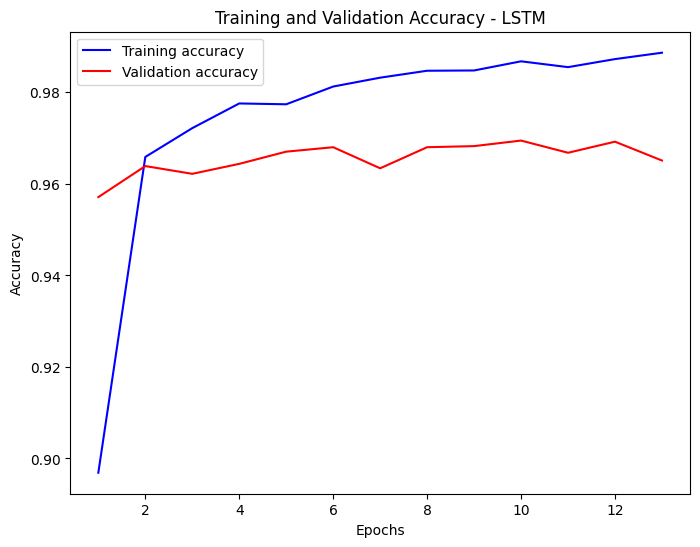

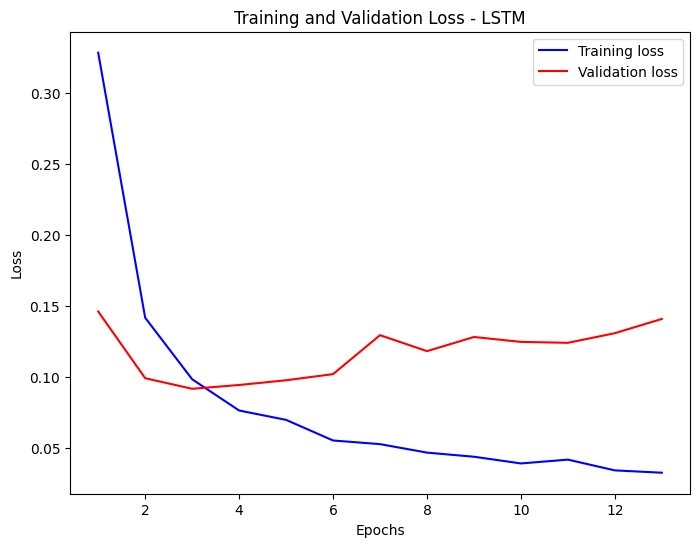


GRU Model Evaluation


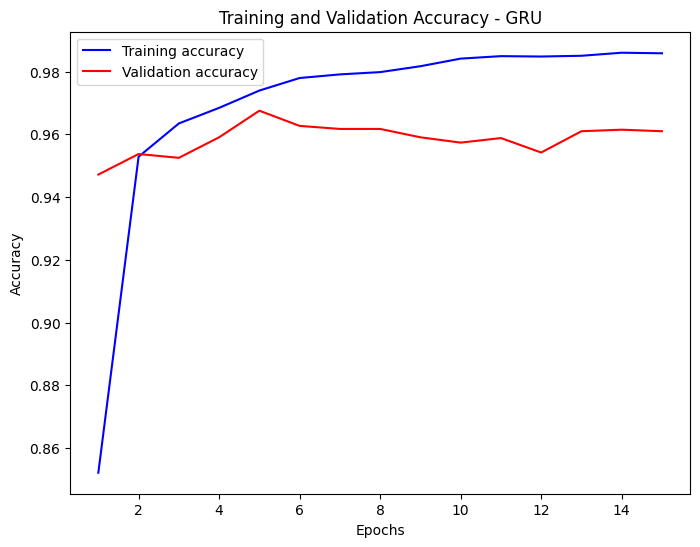

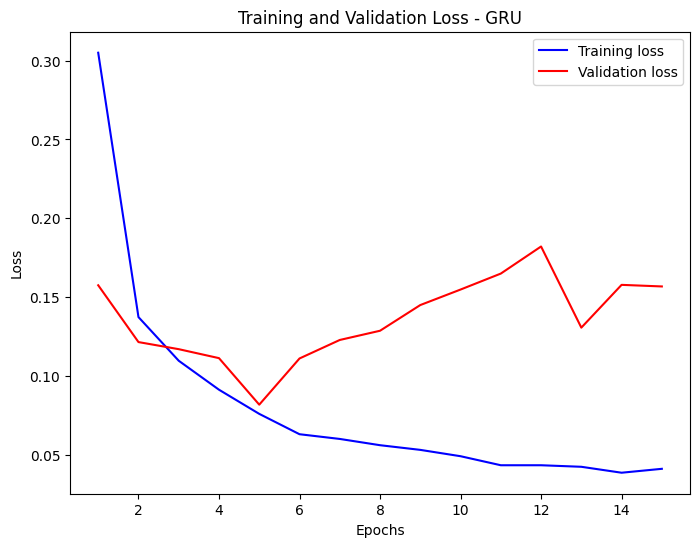

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, precision_score, recall_score

# 1. Summarize history for accuracy and loss and save plots to files
def plot_history(history, model_name):
    # Accuracy plot
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(1, len(acc) + 1)
    
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title(f'Training and Validation Accuracy - {model_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Save the accuracy plot to a file
    plt.savefig(f'{model_name}_accuracy_plot.png')  # Save the accuracy plot
    plt.show()

    # Loss plot
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(f'Training and Validation Loss - {model_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Save the loss plot to a file
    plt.savefig(f'{model_name}_loss_plot.png')  # Save the loss plot
    plt.show()

# 2. Evaluate model and print accuracy
def evaluate_model(model, sequence_array, label_array, model_name):
    scores = model.evaluate(sequence_array, label_array, verbose=0)
    print(f"{model_name} Model Accuracy on Test Data: {scores[1] * 100:.2f}%")

# 3. Make predictions, save to CSV, and calculate confusion matrix, precision, recall
def evaluate_predictions(model, sequence_array, label_array, model_name):
    y_prob = model.predict(sequence_array)
    y_pred = (y_prob > 0.5).astype(int)
    y_true = label_array

    # Save predictions to a CSV
    test_set = pd.DataFrame({'True Label': y_true.flatten(), 'Predicted Label': y_pred.flatten()})
    test_set.to_csv(f'{model_name}_predictions.csv', index=False)

    # Confusion Matrix
    print(f'Confusion matrix for {model_name}\n- x-axis is true labels.\n- y-axis is predicted labels')
    cm = confusion_matrix(y_true, y_pred)
    print(cm)

    # Calculate Precision and Recall
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    print(f'{model_name} Precision = {precision:.2f}, Recall = {recall:.2f}')


# 4. Example for LSTM and GRU models

# LSTM Model
print("\nLSTM Model Evaluation")
plot_history(history_lstm, 'LSTM')  

# GRU Model
print("\nGRU Model Evaluation")
plot_history(history_gru, 'GRU')  


In [25]:
sequence_array = sequence_array_pca.copy()

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import pandas as pd

# Assuming sequence_array and label_array contain your time-series sequences and labels
# Split data into training and test sets (20% test)
X_train, X_test, y_train, y_test = train_test_split(sequence_array, label_array, test_size=0.2, random_state=42)

# Check the shapes to ensure everything is correct
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

# 1. Evaluate LSTM Model
print("\nEvaluating LSTM Model:")
scores_lstm = model_lstm.evaluate(X_test, y_test, verbose=0)
print(f'\nAccuracy of LSTM Model on test data: {scores_lstm[1]*100:.2f}%')

# Make predictions using LSTM model
y_pred_prob_lstm = model_lstm.predict(X_test)
y_pred_lstm = (y_pred_prob_lstm > 0.5).astype(int)  # Convert probabilities to binary labels

# Save predictions and actual values for LSTM to CSV
test_set_lstm = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred_lstm.flatten()})
test_set_lstm.to_csv('lstm_predictions.csv', index=False)

# Compute confusion matrix for LSTM
cm_lstm = confusion_matrix(y_test, y_pred_lstm)
print('\nConfusion matrix of LSTM Model:\n', cm_lstm)

# Calculate precision, recall, and F1-score for LSTM
precision_lstm = precision_score(y_test, y_pred_lstm)
recall_lstm = recall_score(y_test, y_pred_lstm)
f1_lstm = f1_score(y_test, y_pred_lstm)

print(f'\nPrecision of LSTM Model: {precision_lstm:.2f}')
print(f'Recall of LSTM Model: {recall_lstm:.2f}')
print(f'F1-score of LSTM Model: {f1_lstm:.2f}')


# 2. Evaluate GRU Model
print("\nEvaluating GRU Model:")
scores_gru = model_gru.evaluate(X_test, y_test, verbose=0)
print(f'\nAccuracy of GRU Model on test data: {scores_gru[1]*100:.2f}%')

# Make predictions using GRU model
y_pred_prob_gru = model_gru.predict(X_test)
y_pred_gru = (y_pred_prob_gru > 0.5).astype(int)  # Convert probabilities to binary labels

# Save predictions and actual values for GRU to CSV
test_set_gru = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred_gru.flatten()})
test_set_gru.to_csv('gru_predictions.csv', index=False)

# Compute confusion matrix for GRU
cm_gru = confusion_matrix(y_test, y_pred_gru)
print('\nConfusion matrix of GRU Model:\n', cm_gru)

# Calculate precision, recall, and F1-score for GRU
precision_gru = precision_score(y_test, y_pred_gru)
recall_gru = recall_score(y_test, y_pred_gru)
f1_gru = f1_score(y_test, y_pred_gru)

print(f'\nPrecision of GRU Model: {precision_gru:.2f}')
print(f'Recall of GRU Model: {recall_gru:.2f}')
print(f'F1-score of GRU Model: {f1_gru:.2f}')


X_train shape: (16504, 50, 10)
X_test shape: (4127, 50, 10)
y_train shape: (16504, 1)
y_test shape: (4127, 1)

Evaluating LSTM Model:

Accuracy of LSTM Model on test data: 98.86%
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

Confusion matrix of LSTM Model:
 [[2548   30]
 [  17 1532]]

Precision of LSTM Model: 0.98
Recall of LSTM Model: 0.99
F1-score of LSTM Model: 0.98

Evaluating GRU Model:

Accuracy of GRU Model on test data: 98.55%
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

Confusion matrix of GRU Model:
 [[2542   36]
 [  24 1525]]

Precision of GRU Model: 0.98
Recall of GRU Model: 0.98
F1-score of GRU Model: 0.98


### Model Comparison: LSTM vs GRU

| Metric            | **LSTM Model**          | **GRU Model**          | **Comparison**                                  |
|-------------------|-------------------------|-------------------------|-------------------------------------------------|
| **Accuracy**       | 98.86%                  | 98.55%                  | **LSTM** performed slightly better in accuracy with a 0.31% improvement over GRU. Both models performed very well. |
| **Precision**      | 0.98                    | 0.98                    | Both **LSTM** and **GRU** achieved the same precision, indicating they correctly identified positive cases with equal accuracy. |
| **Recall**         | 0.99                    | 0.98                    | **LSTM** had a slight edge in recall, meaning it slightly outperformed GRU in identifying true positives. |
| **F1-score**       | 0.98                    | 0.98                    | Both models achieved the same F1-score, indicating balanced precision and recall. |
| **Confusion Matrix**| TP: 1532, FP: 30, FN: 17, TN: 2548 | TP: 1525, FP: 36, FN: 24, TN: 2542 | The confusion matrices are very similar, but **LSTM** had fewer false positives and false negatives than GRU, indicating better handling of edge cases. |

### Key Observations:
- **LSTM Model** slightly outperformed the GRU model in **accuracy** (98.86% vs 98.55%), with a slightly higher recall (0.99 vs 0.98), meaning it was better at correctly identifying positive cases.
- **Precision** and **F1-score** were identical for both models (0.98), meaning they both maintained good balance between precision and recall.
- The **confusion matrix** showed that LSTM had slightly fewer false positives and false negatives compared to GRU, indicating slightly better classification overall.

<h1> Part 4: Conclusion and Future Directions <h1>

### Conclusion:
Both the **LSTM** and **GRU** models performed very well, with very close results. The **LSTM** model showed a marginally better performance in terms of accuracy and recall, making it slightly superior at identifying true positives with fewer misclassifications.

Both models could be considered strong contenders, and the choice between them could depend on factors such as training time, computational resources, or specific business needs where one model's slight edge in accuracy or recall might be preferred.
    
### Discussion

#### 1. Advantages and Disadvantages of LSTM and GRU in Predictive Maintenance

- **LSTM (Long Short-Term Memory)**:
  - **Advantages**:
    - **Handling Long-Term Dependencies**: LSTM networks are specifically designed to capture long-term dependencies in sequences, making them well-suited for time-series data in predictive maintenance, where historical data can significantly impact future predictions.
    - **Flexible Control of Memory**: LSTMs have three gates (input, forget, and output), giving the model more flexibility in controlling what information to store, use, and discard, which can be valuable in complex datasets.
    - **High Accuracy**: As observed, LSTM models tend to provide slightly better accuracy and recall, making them ideal when predicting critical events like equipment failure.
  - **Disadvantages**:
    - **Computationally Expensive**: Due to their more complex architecture with three gates, LSTMs are computationally heavier than GRUs, requiring more time to train and more memory.
    - **Potential Overfitting**: LSTM models, if not properly tuned, may overfit on the training data, especially when dealing with smaller datasets.

- **GRU (Gated Recurrent Unit)**:
  - **Advantages**:
    - **Computational Efficiency**: GRUs are computationally faster and more efficient than LSTMs because they have fewer gates (only two – reset and update). This makes them quicker to train, which is important in real-time predictive maintenance applications.
    - **Simpler Architecture**: The simpler architecture allows GRUs to perform well with less data and shorter training times, making them a good alternative to LSTMs in situations where computational resources are limited.
    - **Comparable Accuracy**: GRUs often achieve similar accuracy to LSTMs while being less computationally intensive, as seen in the results where both models have very similar F1-scores and precision.
  - **Disadvantages**:
    - **Potentially Less Powerful for Long-Term Dependencies**: GRUs are slightly less capable of handling long-term dependencies compared to LSTMs due to their simplified architecture, although this difference may not be significant for some predictive maintenance tasks.

#### 2. Potential Improvements and Future Work

- **Bi-directional LSTM**:
  - A potential improvement could be the use of **Bi-directional LSTM** models, which allow the network to learn from both past and future data simultaneously. This might be particularly useful in predictive maintenance scenarios where future sensor readings or conditions may influence current predictions.
  - **Advantage**: Bi-directional LSTMs can enhance the model’s ability to capture context from both directions, potentially improving prediction accuracy.

- **Ensemble Models**:
  - Another approach would be to use an ensemble of LSTM and GRU models, or even combine them with other machine learning algorithms (e.g., Random Forests, Gradient Boosting) to create a more robust prediction model.
  - **Advantage**: Ensemble models typically improve prediction accuracy by reducing model variance and bias, potentially leading to better generalization on unseen data.

- **Incorporation of Other RNN Variants**:
  - Beyond LSTM and GRU, other RNN variants such as **Attention-based mechanisms** or **Transformers** could be explored to handle even more complex dependencies in the data.
  - **Advantage**: Attention mechanisms allow the model to focus on the most relevant parts of the input sequence, which could lead to better predictions in noisy environments or when certain sensor readings are more important than others.

- **Transfer Learning**:
  - Transfer learning could be considered as an approach where a model pre-trained on a similar predictive maintenance task could be fine-tuned on a new dataset. This approach is particularly useful when there is limited labeled data for a specific maintenance task.
  
- **Multivariate Time-Series Fusion**:
  - Future work could also explore fusing multiple data sources (sensor readings, historical maintenance logs, operational conditions) to provide the model with richer contextual information.
  - **Advantage**: This would allow the model to better understand the underlying causes of equipment failure, leading to more accurate predictions.

#### Conclusion

In conclusion, while both LSTM and GRU models perform well in predictive maintenance tasks, LSTMs tend to offer slightly better performance in terms of accuracy and recall due to their superior ability to capture long-term dependencies. However, GRUs are more computationally efficient and faster to train, making them a viable alternative in resource-constrained environments. Future work could explore more advanced architectures like Bi-directional LSTMs, ensemble models, and attention mechanisms to further improve the robustness and accuracy of predictions.

